# Empalme con la clase 21

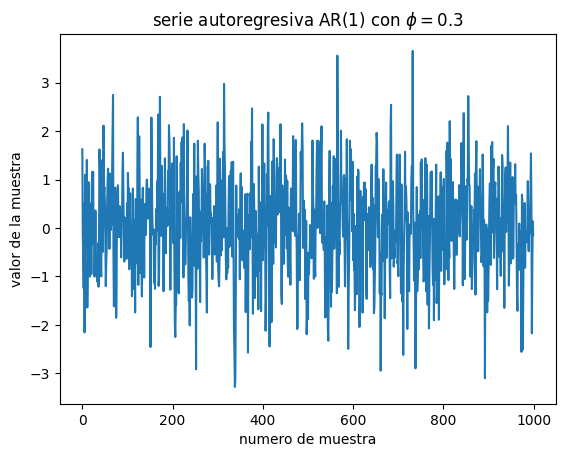

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

np.random.seed(1)
mu, sigma = 0, 1
N=1000

Z = np.random.normal(mu, sigma, N)

# AR(1)
# phi=-0.7
phi=0.3
X = np.zeros(N)
X[0] = Z[0]

for t in range(1, N):
    X[t] = Z[t] + phi*X[t-1]

# grafica
plt.xlabel("numero de muestra")
plt.ylabel("valor de la muestra")
plt.title(f"serie autoregresiva AR(1) con $\phi=${phi}")
plt.plot(X)


In [2]:
def rhok(X, k, verbose=0):
    n = X.size
    Y = np.zeros( shape=(n), dtype='float')

    if k==0:
        return 1
    elif k==1:
        # calculamos simplemente rho_1
        Y=X[1:]  # X_{t-1}
        X=X[:-1]  # X_t  (quitando la ulima muestrar, esto generaa un pequeno error)

        correlation = np.corrcoef(X, Y)[0,1]
        return correlation
    else: 
        # incrementamos k en 1 por que tenemos dos extremos X_t, X_{t-k}.
        # si por ejemplo P_2, necesitamos X_t, X_{t-1}, X_{t-2]} necesitamos
        # 3, es decir uno mas
        k = k+1
        Y=np.zeros( shape=(k, n), dtype='float')
        Y[0] = X  # primera columna de Y es X_t
        for i in range(1, k):
            Y[i][:-i]  = X[i:]  # la columna i es X_{t-i}

        # construyamos la columna de unos
        ones = np.ones(shape=(n,1), dtype='float')

        # pegar la columna de unos
        Xmat = np.column_stack((ones, Y[1]))

        # creamos la matriz Xmat de regresion
        for i in range(2, k-1):
            # stack columns
            Xmat = np.column_stack((Xmat, Y[i]))


        XT = Xmat.transpose()  # Xmat.T
        XTX = XT.dot(Xmat)
        XTXInv = np.linalg.inv(XTX)
        b = np.matmul(Xmat.transpose(), Y[0])
        theta = XTXInv.dot(b)

        if verbose : print("theta first pass", theta)

        # calcule los residuales
        Y_t = X - theta[0] - sum(theta[j]*Y[j] for j in range(1, k-1))

        # este es hat{X_t}

        # proceso en el sentido contrario
        # de X_{k-1} ... X_2, X_1, hasta X_0

        # columna de unos
        ones = np.ones(shape=(n,1), dtype='float') # resta eficiencia, ya se calculo
        Xmat = np.column_stack( ( ones, Y[k-2]))

        # poner las columnas, esta vez en "reversa"
        for i in range(k-3, 0, -1):
            Xmat = np.column_stack( (Xmat, Y[i]))


        XT = Xmat.transpose()  # Xmat.T
        XTX = XT.dot(Xmat)
        XTXInv = np.linalg.inv(XTX)
        b = np.matmul(Xmat.transpose(), Y[k-1])
        theta = XTXInv.dot(b)

        if verbose: print("theta second pass", theta)

        # residuales
        Y_tk = Y[k-1] - theta[0] - sum(theta[j]*Y[k-j-1] for  j in range(1, k-1))

        correlation = np.corrcoef(Y_t, Y_tk)[0,1]
        return correlation

In [3]:
def PACF(X, M):
    global verbose
    rho = np.zeros(M)
    for i in range(M):
        rho[i] = rhok(X, i, verbose)
    return rho


<StemContainer object of 3 artists>

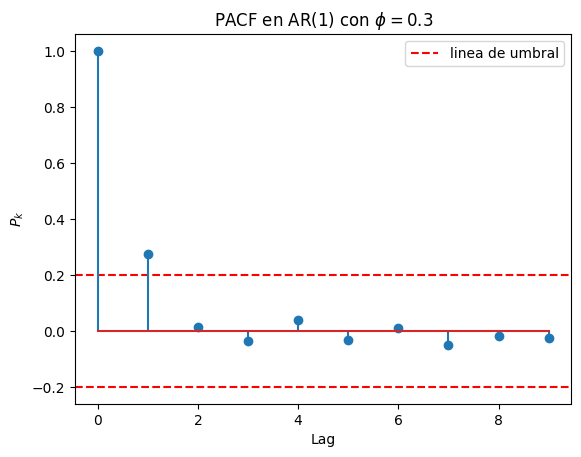

In [4]:
# verificamos comparando con statsmodels
M=10
verbose = 0

rhostattools = np.zeros(M)
rhostattools = sm.tsa.stattools.pacf(X)[0:M]

# nuestra implementacion criolla
rho = PACF(X, M)

plt.axhline(y=0.2, color='r', linestyle='dashed', label='linea de umbral')
plt.axhline(y=-0.2, color='r', linestyle='dashed')

legend=plt.legend(loc='upper right')
plt.title(f"PACF en AR(1) con $\phi=${phi}")
plt.xlabel('Lag')
plt.ylabel('$P_k$')
plt.stem(rho)





<StemContainer object of 3 artists>

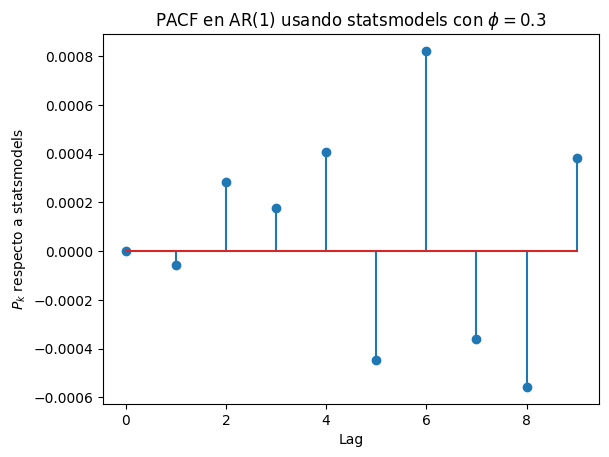

In [5]:
plt.title(f"PACF en AR(1) usando statsmodels con $\phi=${phi}")
plt.xlabel('Lag')
plt.ylabel('$P_k$ respecto a statsmodels')
plt.stem(rhostattools - rho)


Using determinants the solution is: \begin{eqnarray*}
  P_k = 
  \frac{ \det
    \begin{pmatrix}
      1 & \rho_1 & \rho_2 & \cdots & \rho_{{k}-2} & \rho_{1}  \\
      \rho_1 & 1 & \rho_1 & \cdots & \rho_{{k}-3} & \rho_{2}  \\
      \vdots &  & & \cdots &  & \vdots \\
      \vdots &  &  & \cdots &  & \vdots \\
      \rho_{{k}-2} & \rho_{{k}-3} & \rho_{{k}-4} & \cdots & 
      1 & \rho_1 \\
      \rho_{{k}-1} & \rho_{{k}-2} & \rho_{{k}-3} & \cdots & 
      \rho_1 & \rho_k \\
    \end{pmatrix}
  }
  {
    \det \begin{pmatrix}
      1 & \rho_1 & \rho_2 & \cdots & \rho_{{k}-2} & \rho_{{k}-1}  \\
      \rho_1 & 1 & \rho_1 & \cdots & \rho_{{k}-3} & \rho_{{k}-2}  \\
      \vdots &  &  & \cdots &  & \vdots \\
      \vdots &  &  & \cdots &  & \vdots \\
      \rho_{{k}-2} & \rho_{{k}-3} & \rho_{{k}-4} & \cdots & 
      1 & \rho_1 \\
      \rho_{{k}-1} & \rho_{{k}-2} & \rho_{{k}-3} & \cdots & 
      \rho_1 & 1 \\
    \end{pmatrix}
  }
\end{eqnarray*}

Para la matriz $A_k$ en el numerador. los indices de  $\rho$ rho.
Programamos $A$.


* for $J \ge 1$, $A[i,j]=\rho_{j-i}$ , $i=1,2, , k-2$, $j=1, \cdots, ,k-2$
esto no inlcluye ni la ultima fila ni la ultima columna.
*  Por simertria $A[j,i]=A[i,j]$, $i \ne j$ (no repitamos la diagonal que es 1.

* La ultima fila y la ultima columna:
    * La ultima columna:
    $$ A[i, k-1] = \rho_{i+1} \quad , \quad  i = 0,1, ,2, \cdots, k-1 $$

    * ulitma fila
        $$A[k-1, j] = \rho_{k-j-1} \quad, \quad j=0,1,2 \cdots, k-1 $$

Para el denominador es mas facil

$$B[i,j]=\rho_{j-i}$$
con $\rho_{ij} = \rho_{ji}$, $\rho_0=1$ (diagonal), $i,j=0,1,\cdots, k-1$. 

Programemos este cociente de determinantes:



In [6]:
# find the ARC (the rho_i coefficients)
# we  find the autocorrelation using Statsmodel
M=10
import statsmodels.api as sm
rho = sm.tsa.acf(X)[0:M]
np.set_printoptions(precision=2)
print(rho) # the first 10 lags

import numpy as np
M=10
P = np.zeros(M)

P[0]=rho[0]
P[1]=rho[1]


# construyamos las matrices A, B (numerador y denoninador)
for k in range(2, M):
    # build the A and B matrices
    A = np.ones((k,k))
    B = np.ones((k,k))
    
    # build the first part  A (execpt last row and last column )
    for i in range(k):
        for j in range(i, k-1):
            A[i,j] = rho[j-i]
            if i != j : A[j,i] = A[i,j]
            
    # build last column
    for i in range(k):
        A[i, k-1] = rho[i+1]
        
    # build last row
    for j in range(k-1):
        A[k-1, j] = rho[k-j-1]

   # print("\n", A)

   # print(A)
    
    # build matrix B
    for i in range(k):
        for j in range (i+1, k):
            B[i,j] = rho[j-i]
            if i != j : B[j,i] = B[i,j]
                
    print(B)
    P[k] = np.linalg.det(A)/np.linalg.det(B)
    




[ 1.    0.28  0.09 -0.01  0.03 -0.02  0.   -0.05 -0.04 -0.04]
[[1.   0.28]
 [0.28 1.  ]]
[[1.   0.28 0.09]
 [0.28 1.   0.28]
 [0.09 0.28 1.  ]]
[[ 1.    0.28  0.09 -0.01]
 [ 0.28  1.    0.28  0.09]
 [ 0.09  0.28  1.    0.28]
 [-0.01  0.09  0.28  1.  ]]
[[ 1.    0.28  0.09 -0.01  0.03]
 [ 0.28  1.    0.28  0.09 -0.01]
 [ 0.09  0.28  1.    0.28  0.09]
 [-0.01  0.09  0.28  1.    0.28]
 [ 0.03 -0.01  0.09  0.28  1.  ]]
[[ 1.    0.28  0.09 -0.01  0.03 -0.02]
 [ 0.28  1.    0.28  0.09 -0.01  0.03]
 [ 0.09  0.28  1.    0.28  0.09 -0.01]
 [-0.01  0.09  0.28  1.    0.28  0.09]
 [ 0.03 -0.01  0.09  0.28  1.    0.28]
 [-0.02  0.03 -0.01  0.09  0.28  1.  ]]
[[ 1.    0.28  0.09 -0.01  0.03 -0.02  0.  ]
 [ 0.28  1.    0.28  0.09 -0.01  0.03 -0.02]
 [ 0.09  0.28  1.    0.28  0.09 -0.01  0.03]
 [-0.01  0.09  0.28  1.    0.28  0.09 -0.01]
 [ 0.03 -0.01  0.09  0.28  1.    0.28  0.09]
 [-0.02  0.03 -0.01  0.09  0.28  1.    0.28]
 [ 0.   -0.02  0.03 -0.01  0.09  0.28  1.  ]]
[[ 1.    0.28  0.09 -0.01  0.0

<StemContainer object of 3 artists>

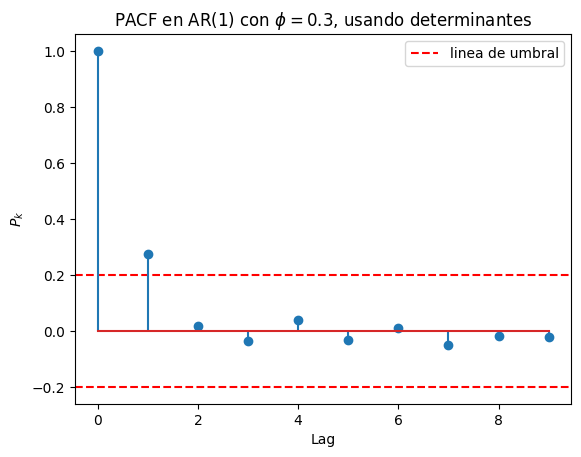

In [7]:
plt.axhline(y=0.2, color='r', linestyle='dashed', label='linea de umbral')
plt.axhline(y=-0.2, color='r', linestyle='dashed')

legend=plt.legend(loc='upper right')
plt.title(f"PACF en AR(1) con $\phi=${phi}, usando determinantes")
plt.xlabel('Lag')
plt.ylabel('$P_k$')
plt.stem(P)

<StemContainer object of 3 artists>

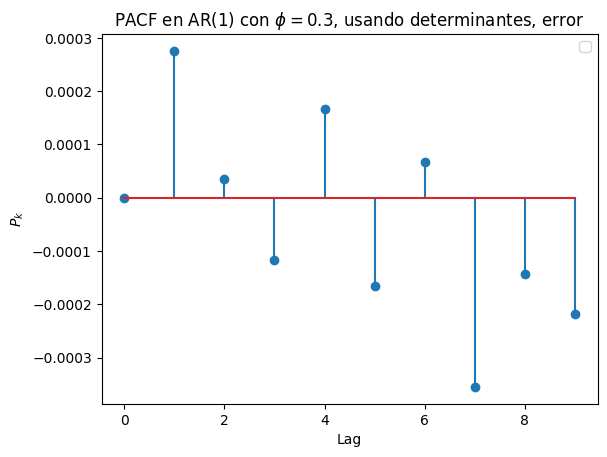

In [8]:
# plt.axhline(y=0.2, color='r', linestyle='dashed', label='linea de umbral')
# plt.axhline(y=-0.2, color='r', linestyle='dashed')

legend=plt.legend(loc='upper right')
plt.title(f"PACF en AR(1) con $\phi=${phi}, usando determinantes, error")
plt.xlabel('Lag')
plt.ylabel('$P_k$')
plt.stem(rhostattools-P)

In [9]:
# find the ARC (the rho_i coefficients)
# we  find the autocorrelation using Statsmodel
M=10
import statsmodels.api as sm
rho = sm.tsa.acf(X)[0:M]
np.set_printoptions(precision=2)
print(rho) # the first 10 lags

[ 1.    0.28  0.09 -0.01  0.03 -0.02  0.   -0.05 -0.04 -0.04]


# Usando el metodo de Yule-Walker

In [10]:
import statsmodels.api as sm

M=10
PYW = np.zeros(M)

PYW[0]=1
PYW[1]=rho[1]

for k in range(2,M):
    rhoYK, sigma = sm.regression.yule_walker(X, order=k, method='mle')

    
    # ultimo coeficientde de los phis.
    PYW[k] = rhoYK[k-1]



<StemContainer object of 3 artists>

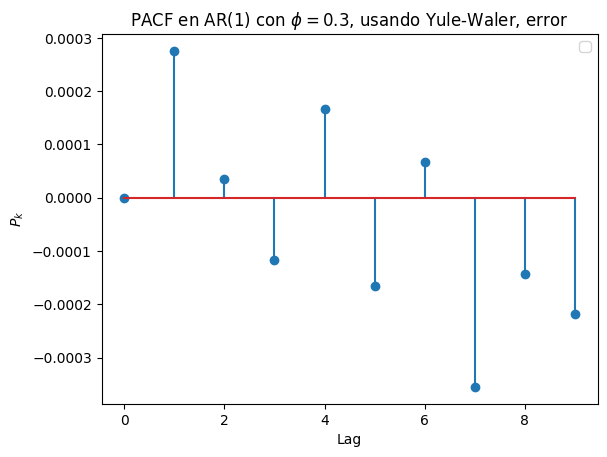

In [11]:
legend=plt.legend(loc='upper right')
plt.title(f"PACF en AR(1) con $\phi=${phi}, usando Yule-Waler, error")
plt.xlabel('Lag')
plt.ylabel('$P_k$')
plt.stem(rhostattools-PYW)

## Matrix Scatter plots: before and after.
Vamos a mostrar el efecto de remover $k=4$ en la regresion lineal multiple. $X_t, X_{t-1}, X_{t-2}, X_{t-3}$, vamos a
ver como al remover los efectos de los interiores, es decir, de $X_{t-1}, X_{t-2}$ la correlacion entre $X_t, X_{t-3}$ es "casi perfecta". 

In [12]:
np.random.seed(1)
mu, sigma = 0, 1
N=1000

Z = np.random.normal(mu, sigma, N)

# AR(1)
# phi=-0.7
phi=0.3
X = np.zeros(N)
X[0] = Z[0]

for t in range(1, N):
    X[t] = Z[t] + phi*X[t-1]

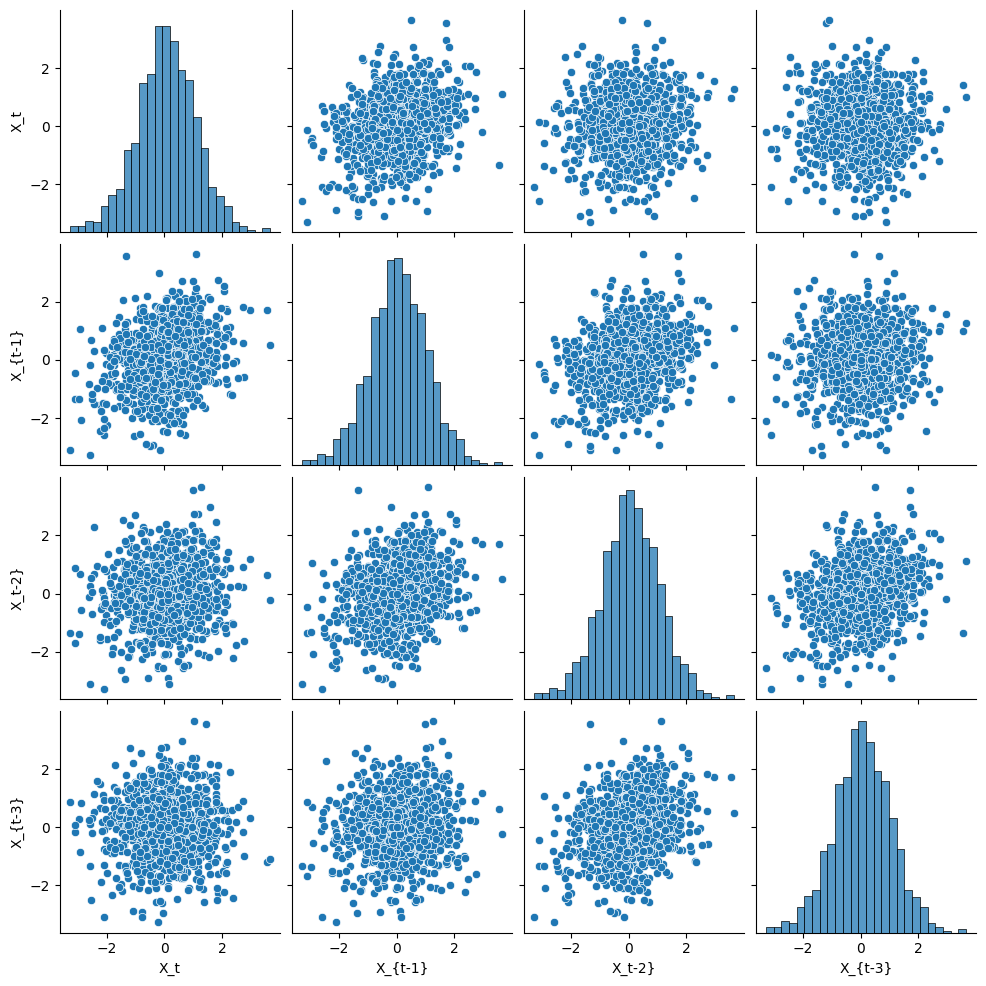

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# construyamos las variables $X_{t-1}, X_{t-2}, \cdots, ,X_{t-k+1}
n=X.size
k=4
Y = np.zeros( shape=(k,n), dtype='float')

Y[0]=X
for i in range(1,k):
    Y[i][:-i] = X[i:]  # X_{t-i}, cortamos la ultima cola para la izquierda por dimensions


# creamos un dataframe
data = np.transpose(Y)
df = pd.DataFrame(data)
X1 = "X_t"
X2 = "X_{t-1}"
X3 = "X_t-2}"
X4 = "X_{t-3}"

df.columns=[X1, X2, X3, X4]
sns.pairplot(df);


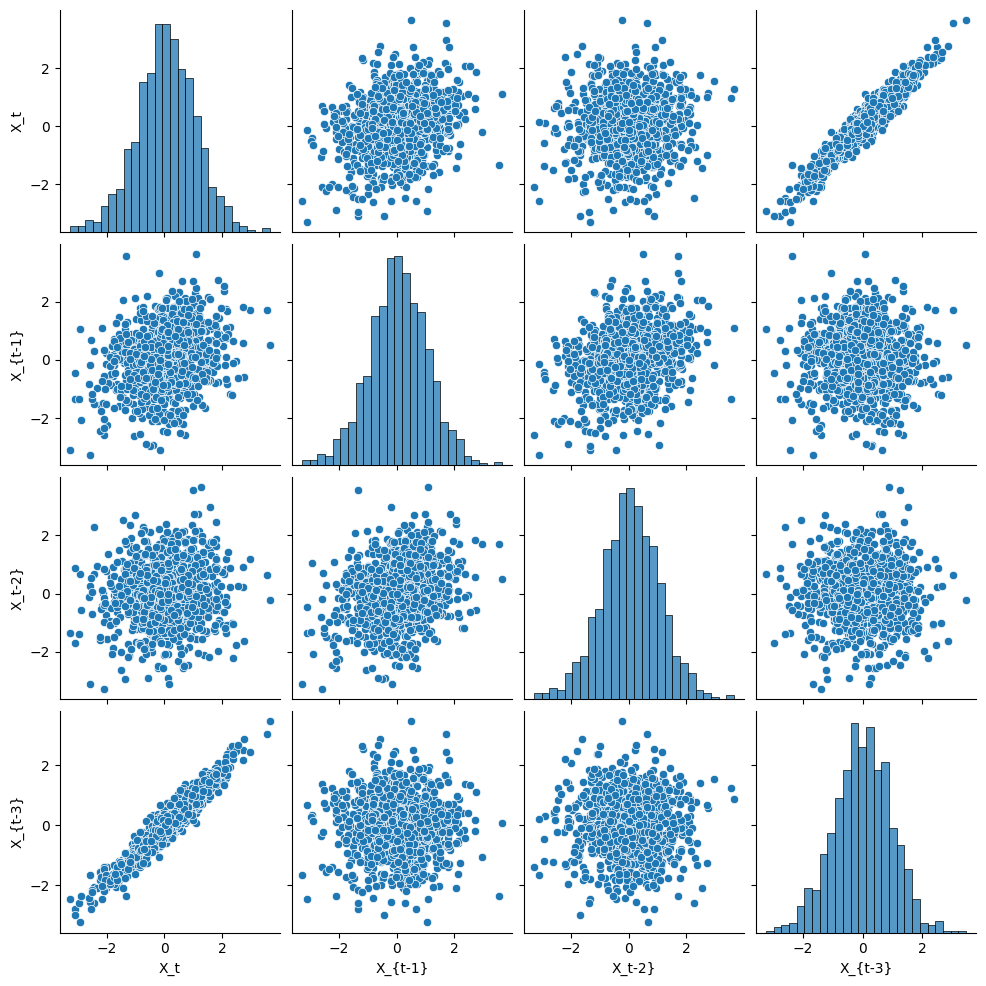

In [16]:
# removamos la interferencia
n=X.size
k=4
Y = np.zeros( shape=(k,n), dtype='float')

Y[0]=X
for i in range(1,k):
    Y[i][:-i] = X[i:]  # X_{t-i}, cortamos la ultima cola para la izquierda por dimensions


# removemos la interferencia de los interiores
# insertamos columna de unos
ones = np.ones(shape=(n,1), dtype='float')
# pegamos los unos a Y[1], por que Y[0] es el b (la derecha)
Xmat = np.column_stack((ones, Y[1]))

# creamos matriz de datos para hacer la regresion
for i in range(2, k-1):
    # pegamos las columnas de Y
    Xmat = np.column_stack((Xmat, Y[i]))

XT = Xmat.transpose()
XTX = XT.dot(Xmat)
XTXInv = np.linalg.inv(XTX)
b = np.matmul(Xmat.transpose(), Y[0]) 
theta = XTXInv.dot(b) 

#  calculo de residuales

Y_t = X - theta[0] - sum( theta[j]*Y[j] for j in range(1, k-1))
# Y_t = X - theta[0] - theta[1]*Y[1] - theta[2]*Y[2]

# por ilustracion veramos solo la remocion en una direccion
# cuando calculamos el PACF lo hacemos en los sentidos

Y[k-1]=Y_t

# creamos un dataframe
data = np.transpose(Y)
df = pd.DataFrame(data)
X1 = "X_t"
X2 = "X_{t-1}"
X3 = "X_t-2}"
X4 = "X_{t-3}"

df.columns=[X1, X2, X3, X4]
sns.pairplot(df);






p=2